In [2]:
import numpy as np
from scipy.special import gammaln
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.spatial.distance as distance

data_dir = "data/"

In [3]:
def poisson_sample(lam, n):
    """
    Manually implemented Poisson sampler
    """
    d = len(lam)
    samples = np.zeros((n, d), dtype=int)
    
    for i in range(n):
        for j in range(d):
            L = np.exp(-lam[j])
            k = 0
            p = 1.0
            while p > L:
                k += 1
                u = np.random.uniform(0, 1)
                p *= u
            samples[i, j] = k - 1
    return samples

theta_values = np.array([2.5, 3.0, 1.2, 4.1, 0.5])

start_time = time.time()
proposal_samples = poisson_sample(theta_values, n=10000)
end_time = time.time() - start_time
print("Our Poisson sampler:", end_time)

start_time = time.time()
proposal_samples = np.random.poisson(theta_values, size=(10000, 5))
end_time = time.time() - start_time
print("Numpy Poisson sampler:", end_time)

Our Poisson sampler: 0.223588228225708
Numpy Poisson sampler: 0.00232696533203125


# MMD

In [4]:
def MMD_weighted(x, y, w, lengthscale):
    #     """ Optimally weighted squared MMD estimate between samples x_i ~ P and y_i ~ Q
    #     """

    if len(x.shape) == 1:
        x = np.array(x, ndmin=2).transpose()
        y = np.array(y, ndmin=2).transpose()
        w = np.array(w, ndmin=2).transpose()

    m = x.shape[0]
    n = y.shape[0]

    xy = np.concatenate((x, y), axis=0)

    K = kernel_matrix(xy, xy, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    # first sum
    sum1 = np.matmul(np.matmul(w.transpose(), kxx), w)

    # second sum
    sum2 = np.sum(np.matmul(w.transpose(), kxy))

    # third sum
    sum3 = (1 / n ** 2) * np.sum(kyy)

    return sum1 - (2 / (n)) * sum2 + sum3


def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    if len(x.shape) == 1:
        x = np.array(x, ndmin=2).transpose()
        y = np.array(y, ndmin=2).transpose()

    m = x.shape[0]
    n = y.shape[0]

    z = np.concatenate((x, y), axis=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * np.sum(kxx) - (2 / (m * n)) * np.sum(kxy) + (1 / n ** 2) * np.sum(kyy)


def median_heuristic(y):
    a = distance.cdist(y, y, 'sqeuclidean')
    return np.sqrt(np.median(a / 2))


def kernel_matrix(x, y, l):
    if len(x.shape) == 1:
        x = np.array(x, ndmin=2).transpose()
        y = np.array(y, ndmin=2).transpose()

    return np.exp(-(1 / (2 * l ** 2)) * distance.cdist(x, y, 'sqeuclidean'))

# ABC

In [5]:
def mad(data, axis=None):
    return np.mean(np.abs(data - np.mean(data, axis)), axis)

def rejection_ABC(s_obs, param, sumStats, epsilon_distance):
    M = param.shape[0]

    norm_factor = mad(sumStats, axis=0)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis=1)

    d_ = np.sort(distance)

    indices = np.where(distance < epsilon_distance)[0]

    posterior_samples = param[indices, :]

    return posterior_samples, indices

# Model

In [6]:
class CMPGM:
    """
    Conway-Maxwell-Poisson graphical model
    """
    def __init__(self, dim, theta_ij=0.1, theta_0j=0.99):
        self.dim = dim
        self.tri = np.triu_indices(dim)
        self.dim_total = dim + int(dim*(dim-1)/2) + dim
        
        self.diag_idx = (np.eye(dim, dtype=bool))[self.tri[0], self.tri[1]]
        self.offd_idx = (~np.eye(dim, dtype=bool))[self.tri[0], self.tri[1]]
        
        # Fix the interaction parameters (theta_ij) and dispersion parameters (theta_0j)
        self.theta_ij = theta_ij
        self.theta_0j = theta_0j

    def _uloglikelihood(self, param, x):
        xa = np.abs(x)
        xx = np.outer(xa, xa)
        np.fill_diagonal(xx, xa)
        t0 = xx[self.tri[0], self.tri[1]]

        t1 = np.dot(t0[self.diag_idx], param)

        t2 = np.dot(t0[self.offd_idx], np.ones_like(t0[self.offd_idx])*self.theta_ij) 

        t3 = np.dot(gammaln(xa + 1), np.ones_like(gammaln(xa + 1))*self.theta_0j)

        return t1 - t2 - t3

    def sample(self, param, num_samples):
        start_time = time.time()
        # proposal_samples = np.random.poisson(param, size=(num_samples, self.dim))  # numpy implementation
        proposal_samples = poisson_sample(param, n=num_samples)  # hand-crafted implementation
        end_time = time.time() - start_time
        
        weights = np.zeros(num_samples)
        
        for i in range(num_samples):
            # Calculate the log-likelihood for the target distribution
            logl_target = self._uloglikelihood(param, proposal_samples[i])
            
            # Calculate the log-likelihood for the proposal distribution
            logl_proposal = np.sum(proposal_samples[i] * np.log(param) - param - gammaln(proposal_samples[i] + 1))
            
            # Weight is the exponent of the difference between the target and proposal log-likelihoods
            weights[i] = np.exp(logl_target - logl_proposal)
        
        total_weight = np.sum(weights)
        weights /= total_weight
        
        # Resample according to the normalized weights
        resampled_indices = np.random.choice(num_samples, size=num_samples, replace=True, p=weights)
        resampled_samples = proposal_samples[resampled_indices]

        marginal_means = np.mean(resampled_samples, axis=0)
        
        # Calculate marginal variances for each dimension
        marginal_variances = np.var(resampled_samples, axis=0)
    
        return np.concatenate([marginal_means, marginal_variances], axis=0)

# Generate reference data

In [ ]:
# generate data for ABC, don't need to run again
for d in dims:
    model = CMPGM(d)
    
    theta_obs = np.ones(d) * 5.
    x_obs = model.sample(theta_obs, m)
    
    start_time = time.time()
    thetas = np.random.rand(n, d) * 10
    xs = np.vstack([model.sample(theta, m) for theta in thetas])
    
    
    thetas_ref = np.random.rand(n_ref, d) * 10
    xs_ref = np.vstack([model.sample(theta, m) for theta in thetas_ref])

    np.save(os.path.join(data_dir, f'cmpgm_cost_dim{d}.npy'), theta_obs)
    np.save(os.path.join(data_dir, f'cmpgm_theta_obs_dim{d}.npy'), theta_obs)
    np.save(os.path.join(data_dir, f'cmpgm_x_obs_dim{d}.npy'), x_obs)
    np.save(os.path.join(data_dir, f'cmpgm_thetas_dim{d}.npy'), thetas)
    np.save(os.path.join(data_dir, f'cmpgm_xs_dim{d}.npy'), xs)
    np.save(os.path.join(data_dir, f'cmpgm_thetas_ref_dim{d}.npy'), thetas_ref)
    np.save(os.path.join(data_dir, f'cmpgm_xs_ref_dim{d}.npy'), xs_ref)

# Run ABC

In [7]:
dims = [4, 6, 8, 10]
eps = [5, 11, 14, 13]
m = 500  # num_samples per theta_o
n = 10000  # num_simulations
n_ref = 100000  # reference num_simulations

In [ ]:
cost_abc = []
mmd_abc = []

k = 5

for i, d in enumerate(dims):
    model = CMPGM(d)

    # load reference data and obs
    theta_obs = np.load(os.path.join(data_dir, f'cmpgm_theta_obs_dim{d}.npy'))
    x_obs = np.load(os.path.join(data_dir, f'cmpgm_x_obs_dim{d}.npy'))
    thetas_ref = np.load(os.path.join(data_dir, f'cmpgm_thetas_ref_dim{d}.npy'))
    xs_ref = np.load(os.path.join(data_dir, f'cmpgm_xs_ref_dim{d}.npy'))

    # get reference posterior samples
    posterior_samples_ref, _ = rejection_ABC(x_obs, thetas_ref, xs_ref, eps[i])
    
    start_time = time.time()
    thetas = np.random.rand(n, d) * 10
    xs = np.vstack([model.sample(theta, m) for theta in thetas])
    end_time = time.time() - start_time
    cost_abc.append(end_time)
    print(f"dim {d} ABC cost: {end_time}")

    posterior_samples, indices = rejection_ABC(x_obs, thetas, xs, eps[i])
    print(indices.shape)
    mmd_abc_ = MMD_unweighted(posterior_samples, posterior_samples_ref, lengthscale=median_heuristic(posterior_samples_ref))

    mmd_abc.append(mmd_abc_)
    print("MMD ABC: ", mmd_abc_)

# CA-ABC

In [9]:
def cost_linear(theta, alpha, beta):
    value = alpha * np.sum(theta, axis=1) + beta
    return value

def calc_acc_prob(cost_linear, alpha, beta, theta, theta_low, k):
    cost = cost_linear(theta, alpha, beta)
    lower_cost = cost_linear(theta_low, alpha, beta)
    return (lower_cost ** k) / (cost ** k)

In [10]:
d = 10
n_step = 10
model = CMPGM(d)

# Range of theta values to test
theta_values = np.linspace(1, 10, n_step)
# theta_values = np.array([9, 10])
theta_values = np.repeat(theta_values[:, np.newaxis], d, axis=1)

sample_times = []

for step in range(n_step):
    start_time = time.time()
    samples = model.sample(theta_values[step], num_samples=10000)
    elapsed_time = time.time() - start_time
    sample_times.append(elapsed_time)

print(sample_times)

[0.4992868900299072, 0.563978910446167, 0.67519211769104, 0.7777209281921387, 0.8745620250701904, 0.9693708419799805, 1.0896790027618408, 1.175140142440796, 1.2926511764526367, 1.3745179176330566]


In [11]:
# Cost function
alpha = (sample_times[-1] - sample_times[0]) / (np.sum(theta_values[-1]) - np.sum(theta_values[0])) 
beta = -alpha * np.sum(theta_values[0]) + sample_times[0]
print(alpha, beta)

0.009724789195590548 0.40203899807400173


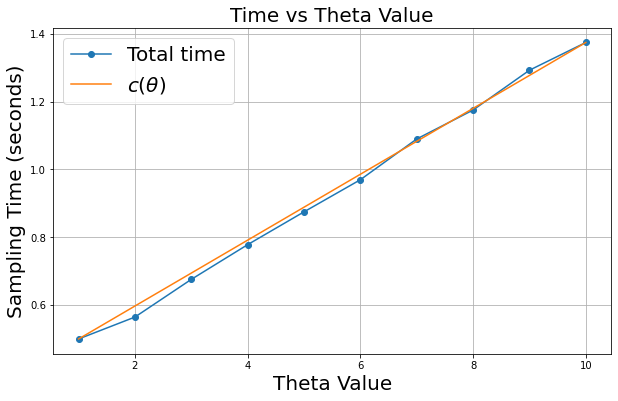

In [12]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(theta_values[:, 0], sample_times, marker='o', label="Total time")
plt.plot(theta_values[:, 0], cost_linear(theta_values, alpha, beta), color = "C1", label = "$c(\\theta)$")
plt.xlabel('Theta Value',fontsize=20)
plt.ylabel('Sampling Time (seconds)',fontsize=20)
plt.title('Time vs Theta Value', fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)
plt.show()

In [162]:
k = 9
d = 10
thetas_ca = np.empty([n, d])
theta_low = np.ones([1, d]) * 1
count = 0

sum_theta = []
prob_list = []

start_time = time.time()
while count < n:
    theta_ = np.random.rand(1, d) * 10
    
    prob = calc_acc_prob(cost_linear, alpha, beta, theta_, theta_low, k)
    
    if calc_acc_prob(cost_linear, alpha, beta, theta_, theta_low, k) > np.random.rand(1):
        thetas_ca[count] = theta_.reshape(-1)
        count += 1
        prob_list.append(prob)
        sum_theta.append(theta_.sum())

# xs = np.vstack([model.sample(theta, m) for theta in thetas_ca])

end_time = time.time() - start_time
print(end_time)

20.54515504837036


In [164]:
thetas_ca.sum()

412467.39313781844

In [166]:
start_time = time.time()
thetas = np.random.rand(n, d) * 10
end_time = time.time() - start_time
print(end_time)

0.0007128715515136719


In [167]:
thetas.sum()

499723.3574658224

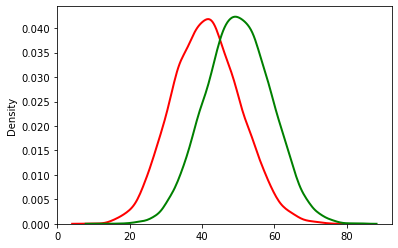

In [169]:
i = 1
sns.kdeplot(thetas_ca.sum(axis=1), color="red", linewidth=2, linestyle="solid", label="ABC")
sns.kdeplot(thetas.sum(axis=1), color="green", linewidth=2, linestyle="solid", label="ABC-REF")
plt.show()

In [82]:
posterior_samples_ca, _ = rejection_ABC(x_obs, thetas_ca, xs, 1.0)

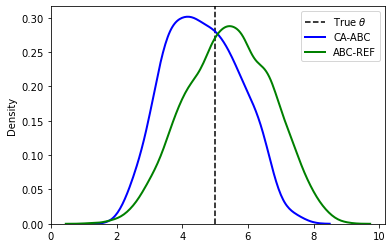

In [83]:
i = 1
plt.axvline(x=theta_obs[i], ls="--", c="black", label="True $\\theta$")
# sns.kdeplot(posterior_samples[:, i], color="red", linewidth=2, linestyle="solid", label="ABC")
sns.kdeplot(posterior_samples[:, i], color="blue", linewidth=2, linestyle="solid", label="CA-ABC")
sns.kdeplot(posterior_samples_ref[:, i], color="green", linewidth=2, linestyle="solid", label="ABC-REF")

plt.legend()
plt.show()

In [294]:
dims = [4, 6, 8, 10]
eps = [4, 10, 12, 12]
cost_caabc = []
mmd_caabc = []
k = 5

for i, d in enumerate(dims):
    model = CMPGM(d)

    # load reference data and obs
    theta_obs = np.load(os.path.join(data_dir, f'cmpgm_theta_obs_dim{d}.npy'))
    x_obs = np.load(os.path.join(data_dir, f'cmpgm_x_obs_dim{d}.npy'))
    thetas_ref = np.load(os.path.join(data_dir, f'cmpgm_thetas_ref_dim{d}.npy'))
    xs_ref = np.load(os.path.join(data_dir, f'cmpgm_xs_ref_dim{d}.npy'))

    # get reference posterior samples
    posterior_samples_ref, _ = rejection_ABC(x_obs, thetas_ref, xs_ref, eps[i])

    
    # # CA-ABC
    # thetas_ca = np.empty([n, d])
    # theta_low = np.ones([1, d]) * 0.01
    # count = 0
    
    # start_time = time.time()
    # while count < n:
    #     theta_ = np.random.rand(1, d) * 10
    #     if calc_acc_prob(cost_linear, alpha, beta, theta_, theta_low, k) > np.random.rand(1):
    #         thetas_ca[count] = theta_.reshape(-1)
    #         count += 1
    # xs_ca = np.vstack([model.sample(theta, m) for theta in thetas_ca])
    # np.save(os.path.join(data_dir, f'cmpgm_thetas_ca_dim{d}.npy'), thetas_ca)
    # np.save(os.path.join(data_dir, f'cmpgm_xs_ca_dim{d}.npy'), xs_ca)
    
    # end_time = time.time() - start_time
    # cost_caabc.append(end_time)
    # print(f"dim {d} CA-ABC cost: {end_time}")

dim 4 ABC cost: 463.9423921108246
dim 6 ABC cost: 621.0342619419098
dim 8 ABC cost: 757.3184809684753
dim 10 ABC cost: 902.4258871078491


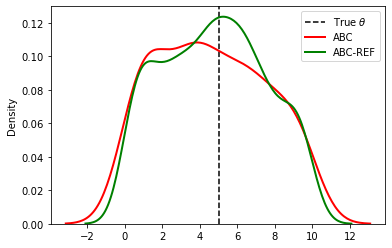

In [324]:
i = 1
plt.axvline(x=theta_obs[i], ls="--", c="black", label="True $\\theta$")
sns.kdeplot(posterior_samples[:, i], color="red", linewidth=2, linestyle="solid", label="ABC")
# sns.kdeplot(posterior_samples[:, i], color="blue", linewidth=2, linestyle="solid", label="CA-ABC")
sns.kdeplot(posterior_samples_ref[:, i], color="green", linewidth=2, linestyle="solid", label="ABC-REF")

plt.legend()
plt.show()

In [16]:
eps

[5, 11, 14, 13]

In [23]:
# dims = [4, 6, 8, 10]
k_mixture = [0., 2., 4., 6.]

num_mixtures = len(k_mixture)
num_per_mixture = int(round(n / num_mixtures))


for i, d in enumerate(dims):

    theta_obs = np.load(os.path.join(data_dir, f'cmpgm_theta_obs_dim{d}.npy'))
    x_obs = np.load(os.path.join(data_dir, f'cmpgm_x_obs_dim{d}.npy'))
    thetas_ref = np.load(os.path.join(data_dir, f'cmpgm_thetas_ref_dim{d}.npy'))
    xs_ref = np.load(os.path.join(data_dir, f'cmpgm_xs_ref_dim{d}.npy'))

    # get reference posterior samples
    posterior_samples_ref, _ = rejection_ABC(x_obs, thetas_ref, xs_ref, eps[i])

    model = CMPGM(d)
    thetas_ca = np.empty([num_mixtures, num_per_mixture, d])
    xs_ca = np.empty([num_mixtures, num_per_mixture, d * 2])
    weights_ca = np.empty([num_mixtures, num_per_mixture])
    posterior_samples_caabc = None
    weights = None
    

    theta_values = np.array([0.1, 10])
    theta_values = np.repeat(theta_values[:, np.newaxis], d, axis=1)    
    
    sample_times = []
    
    for step in range(2):
        start_time = time.time()
        samples = model.sample(theta_values[step], num_samples=10000)
        elapsed_time = time.time() - start_time
        sample_times.append(elapsed_time)

    # determine the cost function
    alpha = (sample_times[-1] - sample_times[0]) / (np.sum(theta_values[-1]) - np.sum(theta_values[0])) 
    beta = -alpha * np.sum(theta_values[0]) + sample_times[0]
    # print(alpha, beta)

    theta_low = np.ones([1, d]) * 0.1
    
    end_time = 0
    for ind in range(num_mixtures):
        count = 0
        weights_for_k = []
        start_time = time.time()
        while count < num_per_mixture:
            theta_ = np.random.rand(1, d) * 10
            # print(calc_acc_prob(cost_linear, alpha, beta, theta_, theta_low, k_mixture[ind]))
            if calc_acc_prob(cost_linear, alpha, beta, theta_, theta_low, k_mixture[ind]) > np.random.rand(1):
                thetas_ca[ind, count] = theta_.reshape(-1)
                weights_for_k.append(cost_linear(theta_, alpha, beta)**k_mixture[ind]) 
                count += 1
        weights_ca[ind] = np.array(weights_for_k).reshape(-1)

        xs_ca[ind] = np.vstack([model.sample(theta, m) for theta in thetas_ca[ind]])
        end_time += time.time() - start_time

        posterior_samples_caabc_per_mixture, indices = rejection_ABC(x_obs, thetas_ca[ind], xs_ca[ind], eps[i])
        
        print(indices.shape)
        weights_per_mixture = weights_ca[ind, indices] / (weights_ca[ind, indices].sum()*num_mixtures)

        if posterior_samples_caabc is None:
            posterior_samples_caabc = posterior_samples_caabc_per_mixture
            weights = weights_per_mixture
        else:
            posterior_samples_caabc = np.concatenate([posterior_samples_caabc,posterior_samples_caabc_per_mixture], axis=0)
            weights = np.concatenate([weights, weights_per_mixture], axis=0)
    print(f"dim {d} ABC cost: {end_time}")
    mmd_caabc_ = MMD_weighted(posterior_samples_caabc, posterior_samples_ref, weights,
                                          lengthscale=median_heuristic(posterior_samples_ref))
    
    print("MMD CA-ABC:", mmd_caabc_)
        

(120,)
(87,)
(74,)
(68,)
dim 4 ABC cost: 220.17337322235107
MMD CA-ABC: 0.0037545933355985772
(29,)
(44,)
(15,)
(2,)
dim 6 ABC cost: 291.5324990749359
MMD CA-ABC: 0.014470160259588416
(16,)
(12,)
(6,)
(2,)
dim 8 ABC cost: 362.7801320552826
MMD CA-ABC: 0.03193741993914567
(20,)
(8,)
(3,)
(5,)
dim 10 ABC cost: 431.6849548816681
MMD CA-ABC: 0.05006722167291611


In [137]:
start_time = time.time()
xs_ca = np.vstack([model.sample(theta, m) for theta in thetas_ca])
print(time.time()-start_time)

419.7090780735016


In [142]:
posterior_samples_caabc, indices = rejection_ABC(x_obs, thetas_ca, xs_ca, 4.0)
posterior_samples_ref, _ = rejection_ABC(x_obs, thetas_ref, xs_ref, 4.0)
mmd_caabc_ = MMD_weighted(posterior_samples_caabc, posterior_samples_ref, weights_ca[indices] / weights_ca[indices].sum(),
                                          lengthscale=median_heuristic(posterior_samples_ref))

In [143]:
mmd_caabc_

0.008452184874395696

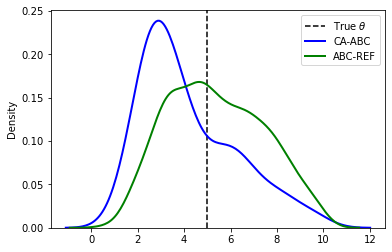

In [145]:
i = 1
plt.axvline(x=theta_obs[i], ls="--", c="black", label="True $\\theta$")
# sns.kdeplot(posterior_samples[:, i], color="red", linewidth=2, linestyle="solid", label="ABC")
sns.kdeplot(posterior_samples_caabc[:, i], color="blue", linewidth=2, linestyle="solid", label="CA-ABC")
sns.kdeplot(posterior_samples_ref[:, i], color="green", linewidth=2, linestyle="solid", label="ABC-REF")

plt.legend()
plt.show()

In [34]:
thetas = np.load(os.path.join(data_dir, f'cmpgm_thetas_dim10.npy'))
start_time = time.time()
# xs = np.vstack([model.sample(theta, m) for theta in thetas])
print(time.time()-start_time)

3.600120544433594e-05


In [35]:
print(calc_acc_prob(cost_linear, alpha, beta, thetas_ca, theta_low, k_mixture[ind]).mean())

0.012276789938521396


In [36]:
thetas_ca.sum()

905335.0662462141

In [37]:
thetas.sum()

999535.8991225484

In [269]:
start_time = time.time()
samples = model.sample(thetas_ca[1], num_samples=100000)
elapsed_time = time.time() - start_time
print(elapsed_time)

8.377501010894775


In [276]:
theta_values = np.array([5])
theta_values = np.repeat(theta_values[:, np.newaxis], d, axis=1)

print(calc_acc_prob(cost_linear, alpha, beta, theta_values, theta_low, k_mixture[ind]))

[0.00239308]


In [16]:
n_run = 10
cost_abc = np.empty([n_run, 4])
cost_caabc = np.empty([n_run, 4])
mmd_abc = np.empty([n_run, 4])
mmd_caabc = np.empty([n_run, 4])

for i in range(n_run):
    checkpoint_path = f"sims/cmpgm/mixture/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    cost_abc[i] = checkpoint['cost_abc']
    # cost_caabc[i] = checkpoint['cost_caabc']
    
    mmd_abc[i] = checkpoint['mmd_abc']
    mmd_caabc[i] = checkpoint['mmd_caabc']

cost_abc_mean = cost_abc.mean(axis=0)
cost_abc_std = cost_abc.std(axis=0)

cost_caabc_mean = cost_caabc.mean(axis=0)
cost_caabc_std = cost_caabc.std(axis=0)

mmd_abc_mean = mmd_abc.mean(axis=0)
mmd_abc_std = mmd_abc.std(axis=0)

mmd_caabc_mean = mmd_caabc.mean(axis=0)
mmd_caabc_std = mmd_caabc.std(axis=0)
    

/var/folders/h_/4nmj4c_s4z3g9k27jvr24shm0000gp/T/ipykernel_12424/3482645943.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

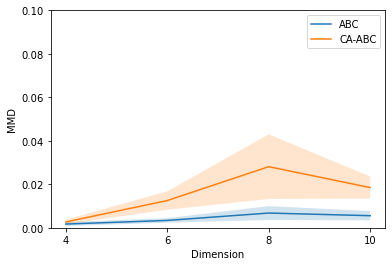

In [29]:

plt.plot(dims, mmd_abc_mean, label="ABC")
plt.plot(dims, mmd_caabc_mean, label="CA-ABC")
plt.fill_between(dims, mmd_abc_mean - mmd_abc_std, mmd_abc_mean + mmd_abc_std, alpha=0.2)
plt.fill_between(dims, mmd_caabc_mean - mmd_caabc_std, mmd_caabc_mean + mmd_caabc_std, alpha=0.2)

plt.ylim(0, 0.1)
plt.xticks([4, 6, 8, 10])
plt.xlabel("Dimension")
plt.ylabel("MMD")
plt.legend()
plt.show()